<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[17:10:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


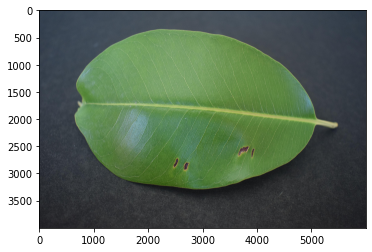

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

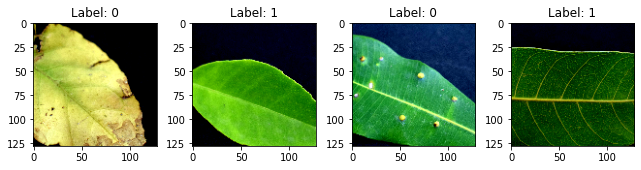

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[17:10:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[17:10:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2452479746146958 samples/sec                   batch loss = 0.6102099418640137 | accuracy = 0.3


Epoch[1] Batch[10] Speed: 1.2564085032680654 samples/sec                   batch loss = 0.39198169112205505 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2580478935373898 samples/sec                   batch loss = 0.8315549492835999 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2584111895069194 samples/sec                   batch loss = 0.44700297713279724 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2572025568759373 samples/sec                   batch loss = 2.670912742614746 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.259849539391512 samples/sec                   batch loss = 1.2898705005645752 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.258410151219544 samples/sec                   batch loss = 0.8359342217445374 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.259937150394847 samples/sec                   batch loss = 0.6034493446350098 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2636110974912707 samples/sec                   batch loss = 1.8364030122756958 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2612114404996189 samples/sec                   batch loss = 0.5242149233818054 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.264634638964914 samples/sec                   batch loss = 0.28254780173301697 | accuracy = 0.6227272727272727


Epoch[1] Batch[60] Speed: 1.257285465923671 samples/sec                   batch loss = 0.6877306699752808 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2611578749075587 samples/sec                   batch loss = 0.3161359131336212 | accuracy = 0.6076923076923076


Epoch[1] Batch[70] Speed: 1.257492409384249 samples/sec                   batch loss = 0.628588080406189 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2589326261730351 samples/sec                   batch loss = 0.6785875558853149 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2592865085742144 samples/sec                   batch loss = 0.3302638828754425 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2575470779552969 samples/sec                   batch loss = 0.5961899757385254 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2563455604478124 samples/sec                   batch loss = 0.4278567135334015 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.2615037138200211 samples/sec                   batch loss = 1.0465480089187622 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.2624202927329637 samples/sec                   batch loss = 0.5226201415061951 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2606858412382862 samples/sec                   batch loss = 0.3349924087524414 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2554278202276248 samples/sec                   batch loss = 0.9592368006706238 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2547364062873474 samples/sec                   batch loss = 0.607840895652771 | accuracy = 0.6326086956521739


Epoch[1] Batch[120] Speed: 1.2462909449069535 samples/sec                   batch loss = 0.6040157675743103 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.2526904834828723 samples/sec                   batch loss = 1.1606025695800781 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2581959231137223 samples/sec                   batch loss = 0.8404610753059387 | accuracy = 0.6211538461538462


Epoch[1] Batch[135] Speed: 1.2487204445884739 samples/sec                   batch loss = 0.8136346936225891 | accuracy = 0.6166666666666667


Epoch[1] Batch[140] Speed: 1.254519674775738 samples/sec                   batch loss = 0.42386436462402344 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2492922977210557 samples/sec                   batch loss = 0.47698280215263367 | accuracy = 0.6189655172413793


Epoch[1] Batch[150] Speed: 1.2520250649549136 samples/sec                   batch loss = 0.34202316403388977 | accuracy = 0.625


Epoch[1] Batch[155] Speed: 1.257322495883047 samples/sec                   batch loss = 0.406990647315979 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2604910089087475 samples/sec                   batch loss = 2.176551580429077 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2585747883641882 samples/sec                   batch loss = 0.6404121518135071 | accuracy = 0.6333333333333333


Epoch[1] Batch[170] Speed: 1.2579843147264225 samples/sec                   batch loss = 0.27126866579055786 | accuracy = 0.6352941176470588


Epoch[1] Batch[175] Speed: 1.2524973663702106 samples/sec                   batch loss = 0.7178457975387573 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2517766725463177 samples/sec                   batch loss = 0.6705706715583801 | accuracy = 0.6416666666666667


Epoch[1] Batch[185] Speed: 1.2472178078732425 samples/sec                   batch loss = 0.4585368037223816 | accuracy = 0.6391891891891892


Epoch[1] Batch[190] Speed: 1.2508153269538622 samples/sec                   batch loss = 0.25936323404312134 | accuracy = 0.6407894736842106


Epoch[1] Batch[195] Speed: 1.2505806512014686 samples/sec                   batch loss = 0.5184226036071777 | accuracy = 0.6397435897435897


Epoch[1] Batch[200] Speed: 1.24945613945589 samples/sec                   batch loss = 0.2722541093826294 | accuracy = 0.64375


Epoch[1] Batch[205] Speed: 1.2479848729250576 samples/sec                   batch loss = 0.3746245801448822 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2482692828224673 samples/sec                   batch loss = 0.7991955876350403 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2460852652407293 samples/sec                   batch loss = 0.7271102666854858 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2384254623551778 samples/sec                   batch loss = 0.42527303099632263 | accuracy = 0.6477272727272727


Epoch[1] Batch[225] Speed: 1.2526470853949816 samples/sec                   batch loss = 0.8153654336929321 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2474227486324216 samples/sec                   batch loss = 0.3097253441810608 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2526098627067075 samples/sec                   batch loss = 0.8444759845733643 | accuracy = 0.6446808510638298


Epoch[1] Batch[240] Speed: 1.244202227239409 samples/sec                   batch loss = 0.29803597927093506 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2544277506920312 samples/sec                   batch loss = 0.8752410411834717 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.2459390536673707 samples/sec                   batch loss = 0.5898936986923218 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2504478285180123 samples/sec                   batch loss = 0.4136227071285248 | accuracy = 0.6529411764705882


Epoch[1] Batch[260] Speed: 1.2486878229087688 samples/sec                   batch loss = 0.16576050221920013 | accuracy = 0.6538461538461539


Epoch[1] Batch[265] Speed: 1.2503888363335347 samples/sec                   batch loss = 0.6360332369804382 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.2479710410772595 samples/sec                   batch loss = 0.8236842155456543 | accuracy = 0.6518518518518519


Epoch[1] Batch[275] Speed: 1.2488321704910497 samples/sec                   batch loss = 0.6887867450714111 | accuracy = 0.6509090909090909


Epoch[1] Batch[280] Speed: 1.2560662983640503 samples/sec                   batch loss = 0.5557838678359985 | accuracy = 0.6464285714285715


Epoch[1] Batch[285] Speed: 1.2579812019823016 samples/sec                   batch loss = 0.48285603523254395 | accuracy = 0.6456140350877193


Epoch[1] Batch[290] Speed: 1.260433622049078 samples/sec                   batch loss = 0.6685699224472046 | accuracy = 0.6474137931034483


Epoch[1] Batch[295] Speed: 1.2594215938515614 samples/sec                   batch loss = 0.657524049282074 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.2613996671998806 samples/sec                   batch loss = 0.6827762126922607 | accuracy = 0.6458333333333334


Epoch[1] Batch[305] Speed: 1.258907120308611 samples/sec                   batch loss = 0.7518749833106995 | accuracy = 0.6467213114754098


Epoch[1] Batch[310] Speed: 1.260576435991988 samples/sec                   batch loss = 0.40615397691726685 | accuracy = 0.6491935483870968


Epoch[1] Batch[315] Speed: 1.2523751675646995 samples/sec                   batch loss = 0.49907755851745605 | accuracy = 0.6507936507936508


Epoch[1] Batch[320] Speed: 1.249586983190862 samples/sec                   batch loss = 1.607086181640625 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.2547364062873474 samples/sec                   batch loss = 0.6157263517379761 | accuracy = 0.65


Epoch[1] Batch[330] Speed: 1.253778943615349 samples/sec                   batch loss = 0.5235651135444641 | accuracy = 0.6492424242424243


Epoch[1] Batch[335] Speed: 1.2561774615898194 samples/sec                   batch loss = 0.501498281955719 | accuracy = 0.6492537313432836


Epoch[1] Batch[340] Speed: 1.2525561836298233 samples/sec                   batch loss = 0.4182749390602112 | accuracy = 0.6507352941176471


Epoch[1] Batch[345] Speed: 1.2497557432006625 samples/sec                   batch loss = 0.44784846901893616 | accuracy = 0.6521739130434783


Epoch[1] Batch[350] Speed: 1.2576764163257896 samples/sec                   batch loss = 0.24048908054828644 | accuracy = 0.6535714285714286


Epoch[1] Batch[355] Speed: 1.251356526254542 samples/sec                   batch loss = 0.6631587743759155 | accuracy = 0.6549295774647887


Epoch[1] Batch[360] Speed: 1.2561733231814491 samples/sec                   batch loss = 0.7972069978713989 | accuracy = 0.6541666666666667


Epoch[1] Batch[365] Speed: 1.2535363173793246 samples/sec                   batch loss = 0.39770424365997314 | accuracy = 0.6561643835616439


Epoch[1] Batch[370] Speed: 1.2534006187955526 samples/sec                   batch loss = 0.1162949949502945 | accuracy = 0.6574324324324324


Epoch[1] Batch[375] Speed: 1.2502161787232444 samples/sec                   batch loss = 0.3444437086582184 | accuracy = 0.6613333333333333


Epoch[1] Batch[380] Speed: 1.2517420231477896 samples/sec                   batch loss = 0.9532688856124878 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.2528810404133133 samples/sec                   batch loss = 0.8613987565040588 | accuracy = 0.6649350649350649


Epoch[1] Batch[390] Speed: 1.2544416322410603 samples/sec                   batch loss = 0.8915323615074158 | accuracy = 0.6647435897435897


Epoch[1] Batch[395] Speed: 1.2513948879122045 samples/sec                   batch loss = 0.9307653307914734 | accuracy = 0.6645569620253164


Epoch[1] Batch[400] Speed: 1.247914881355148 samples/sec                   batch loss = 0.632651686668396 | accuracy = 0.665625


Epoch[1] Batch[405] Speed: 1.2512189663171598 samples/sec                   batch loss = 0.3522183299064636 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2511534633282222 samples/sec                   batch loss = 0.11032586544752121 | accuracy = 0.6701219512195122


Epoch[1] Batch[415] Speed: 1.2538881092101033 samples/sec                   batch loss = 0.421169251203537 | accuracy = 0.6704819277108434


Epoch[1] Batch[420] Speed: 1.2476804575091704 samples/sec                   batch loss = 1.0650156736373901 | accuracy = 0.6696428571428571


Epoch[1] Batch[425] Speed: 1.251047478717292 samples/sec                   batch loss = 0.32058602571487427 | accuracy = 0.6694117647058824


Epoch[1] Batch[430] Speed: 1.2566358649909442 samples/sec                   batch loss = 0.655917227268219 | accuracy = 0.6697674418604651


Epoch[1] Batch[435] Speed: 1.2538635570074952 samples/sec                   batch loss = 0.7491875886917114 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.25958507728101 samples/sec                   batch loss = 0.7773643732070923 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.2556735287863772 samples/sec                   batch loss = 0.8316159248352051 | accuracy = 0.6702247191011236


Epoch[1] Batch[450] Speed: 1.2705276518146267 samples/sec                   batch loss = 1.069542646408081 | accuracy = 0.6705555555555556


Epoch[1] Batch[455] Speed: 1.2668331391489969 samples/sec                   batch loss = 0.9438645243644714 | accuracy = 0.6697802197802197


Epoch[1] Batch[460] Speed: 1.265898012806404 samples/sec                   batch loss = 0.35175371170043945 | accuracy = 0.6711956521739131


Epoch[1] Batch[465] Speed: 1.2686274371915762 samples/sec                   batch loss = 0.560401439666748 | accuracy = 0.671505376344086


Epoch[1] Batch[470] Speed: 1.2644344865638326 samples/sec                   batch loss = 1.4679003953933716 | accuracy = 0.6723404255319149


Epoch[1] Batch[475] Speed: 1.268241058399568 samples/sec                   batch loss = 0.46258145570755005 | accuracy = 0.6726315789473685


Epoch[1] Batch[480] Speed: 1.2638723021020448 samples/sec                   batch loss = 0.45712506771087646 | accuracy = 0.6713541666666667


Epoch[1] Batch[485] Speed: 1.266502441932022 samples/sec                   batch loss = 0.48930755257606506 | accuracy = 0.6706185567010309


Epoch[1] Batch[490] Speed: 1.2663601938833862 samples/sec                   batch loss = 1.0489834547042847 | accuracy = 0.6688775510204081


Epoch[1] Batch[495] Speed: 1.2692806637184912 samples/sec                   batch loss = 0.5120196342468262 | accuracy = 0.6676767676767676


Epoch[1] Batch[500] Speed: 1.2614572369096266 samples/sec                   batch loss = 0.981298565864563 | accuracy = 0.667


Epoch[1] Batch[505] Speed: 1.2681387731253584 samples/sec                   batch loss = 0.23131392896175385 | accuracy = 0.6683168316831684


Epoch[1] Batch[510] Speed: 1.266176026314266 samples/sec                   batch loss = 0.4162406325340271 | accuracy = 0.6696078431372549


Epoch[1] Batch[515] Speed: 1.2620711978930295 samples/sec                   batch loss = 0.3646868169307709 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.2680269204914956 samples/sec                   batch loss = 0.8623862266540527 | accuracy = 0.6701923076923076


Epoch[1] Batch[525] Speed: 1.2640246578449021 samples/sec                   batch loss = 0.3883557617664337 | accuracy = 0.6714285714285714


Epoch[1] Batch[530] Speed: 1.2693636368657435 samples/sec                   batch loss = 0.6112686395645142 | accuracy = 0.6707547169811321


Epoch[1] Batch[535] Speed: 1.2687916882925168 samples/sec                   batch loss = 0.6420854330062866 | accuracy = 0.6710280373831776


Epoch[1] Batch[540] Speed: 1.2603485930432838 samples/sec                   batch loss = 0.8065740466117859 | accuracy = 0.6689814814814815


Epoch[1] Batch[545] Speed: 1.2617610112368762 samples/sec                   batch loss = 1.0135154724121094 | accuracy = 0.6697247706422018


Epoch[1] Batch[550] Speed: 1.2635559004258168 samples/sec                   batch loss = 1.0838066339492798 | accuracy = 0.6695454545454546


Epoch[1] Batch[555] Speed: 1.2650026080870755 samples/sec                   batch loss = 0.46541261672973633 | accuracy = 0.6693693693693694


Epoch[1] Batch[560] Speed: 1.2651673529340126 samples/sec                   batch loss = 0.794596254825592 | accuracy = 0.6691964285714286


Epoch[1] Batch[565] Speed: 1.2630111357649103 samples/sec                   batch loss = 0.3004627823829651 | accuracy = 0.6694690265486726


Epoch[1] Batch[570] Speed: 1.2664577947824303 samples/sec                   batch loss = 0.3429830074310303 | accuracy = 0.6710526315789473


Epoch[1] Batch[575] Speed: 1.271801387160634 samples/sec                   batch loss = 0.46698641777038574 | accuracy = 0.6721739130434783


Epoch[1] Batch[580] Speed: 1.2704369263864088 samples/sec                   batch loss = 1.7608377933502197 | accuracy = 0.6706896551724137


Epoch[1] Batch[585] Speed: 1.2687552270159332 samples/sec                   batch loss = 0.4497106671333313 | accuracy = 0.67008547008547


Epoch[1] Batch[590] Speed: 1.267352772322103 samples/sec                   batch loss = 0.2665475904941559 | accuracy = 0.6716101694915254


Epoch[1] Batch[595] Speed: 1.2636135719554156 samples/sec                   batch loss = 0.7089181542396545 | accuracy = 0.6714285714285714


Epoch[1] Batch[600] Speed: 1.267361867304532 samples/sec                   batch loss = 0.47536641359329224 | accuracy = 0.67125


Epoch[1] Batch[605] Speed: 1.2662489414726852 samples/sec                   batch loss = 0.2311643809080124 | accuracy = 0.6710743801652893


Epoch[1] Batch[610] Speed: 1.2701752133309672 samples/sec                   batch loss = 0.3956270217895508 | accuracy = 0.671311475409836


Epoch[1] Batch[615] Speed: 1.2662918535316876 samples/sec                   batch loss = 0.22021357715129852 | accuracy = 0.6727642276422764


Epoch[1] Batch[620] Speed: 1.2669289951963492 samples/sec                   batch loss = 0.4689280390739441 | accuracy = 0.6729838709677419


Epoch[1] Batch[625] Speed: 1.2652077109936892 samples/sec                   batch loss = 0.6326867341995239 | accuracy = 0.6724


Epoch[1] Batch[630] Speed: 1.2665874427440316 samples/sec                   batch loss = 0.4179677665233612 | accuracy = 0.6726190476190477


Epoch[1] Batch[635] Speed: 1.2641628572229433 samples/sec                   batch loss = 0.3432551920413971 | accuracy = 0.6736220472440945


Epoch[1] Batch[640] Speed: 1.2608631085688589 samples/sec                   batch loss = 0.8287951350212097 | accuracy = 0.67421875


Epoch[1] Batch[645] Speed: 1.263224438820314 samples/sec                   batch loss = 0.3490770757198334 | accuracy = 0.6748062015503876


Epoch[1] Batch[650] Speed: 1.2608611186535676 samples/sec                   batch loss = 0.39500412344932556 | accuracy = 0.6757692307692308


Epoch[1] Batch[655] Speed: 1.2612925085888125 samples/sec                   batch loss = 0.47616779804229736 | accuracy = 0.6767175572519084


Epoch[1] Batch[660] Speed: 1.2610409944665089 samples/sec                   batch loss = 0.5941283702850342 | accuracy = 0.6772727272727272


Epoch[1] Batch[665] Speed: 1.2595535875831552 samples/sec                   batch loss = 0.32186731696128845 | accuracy = 0.6778195488721804


Epoch[1] Batch[670] Speed: 1.2601240504313524 samples/sec                   batch loss = 0.3896882236003876 | accuracy = 0.6779850746268656


Epoch[1] Batch[675] Speed: 1.2695542088581613 samples/sec                   batch loss = 0.5761743783950806 | accuracy = 0.6766666666666666


Epoch[1] Batch[680] Speed: 1.258289910252842 samples/sec                   batch loss = 0.8188073635101318 | accuracy = 0.6772058823529412


Epoch[1] Batch[685] Speed: 1.2619697155237803 samples/sec                   batch loss = 0.3502803146839142 | accuracy = 0.6777372262773723


Epoch[1] Batch[690] Speed: 1.2661733506883714 samples/sec                   batch loss = 0.797096848487854 | accuracy = 0.677536231884058


Epoch[1] Batch[695] Speed: 1.2650131954928803 samples/sec                   batch loss = 0.22657498717308044 | accuracy = 0.6784172661870503


Epoch[1] Batch[700] Speed: 1.2645196865551036 samples/sec                   batch loss = 0.5008074641227722 | accuracy = 0.6796428571428571


Epoch[1] Batch[705] Speed: 1.2601676841943417 samples/sec                   batch loss = 0.5221768021583557 | accuracy = 0.6797872340425531


Epoch[1] Batch[710] Speed: 1.2668449051283037 samples/sec                   batch loss = 0.3896009624004364 | accuracy = 0.6799295774647888


Epoch[1] Batch[715] Speed: 1.2681372394511154 samples/sec                   batch loss = 0.8377952575683594 | accuracy = 0.6804195804195804


Epoch[1] Batch[720] Speed: 1.2667052580086913 samples/sec                   batch loss = 0.979180097579956 | accuracy = 0.6802083333333333


Epoch[1] Batch[725] Speed: 1.2720578874800166 samples/sec                   batch loss = 0.6046119332313538 | accuracy = 0.6810344827586207


Epoch[1] Batch[730] Speed: 1.2723575259657474 samples/sec                   batch loss = 0.5467402338981628 | accuracy = 0.6815068493150684


Epoch[1] Batch[735] Speed: 1.2758371180703343 samples/sec                   batch loss = 0.669247567653656 | accuracy = 0.6819727891156463


Epoch[1] Batch[740] Speed: 1.2703345751816453 samples/sec                   batch loss = 0.5319430232048035 | accuracy = 0.6827702702702703


Epoch[1] Batch[745] Speed: 1.2706326323977688 samples/sec                   batch loss = 0.398910254240036 | accuracy = 0.6825503355704698


Epoch[1] Batch[750] Speed: 1.2642432572551572 samples/sec                   batch loss = 0.43450629711151123 | accuracy = 0.684


Epoch[1] Batch[755] Speed: 1.2618153872859201 samples/sec                   batch loss = 0.594483494758606 | accuracy = 0.6844370860927153


Epoch[1] Batch[760] Speed: 1.2669505217523096 samples/sec                   batch loss = 0.6108314394950867 | accuracy = 0.6832236842105263


Epoch[1] Batch[765] Speed: 1.2628074097095294 samples/sec                   batch loss = 0.508997917175293 | accuracy = 0.6849673202614379


Epoch[1] Batch[770] Speed: 1.263013322635336 samples/sec                   batch loss = 0.45342183113098145 | accuracy = 0.685064935064935


Epoch[1] Batch[775] Speed: 1.2615023858607681 samples/sec                   batch loss = 0.34285101294517517 | accuracy = 0.6858064516129032


Epoch[1] Batch[780] Speed: 1.265702234652002 samples/sec                   batch loss = 0.34329953789711 | accuracy = 0.6862179487179487


Epoch[1] Batch[785] Speed: 1.2768744476487455 samples/sec                   batch loss = 0.4613226354122162 | accuracy = 0.6859872611464968


[Epoch 1] training: accuracy=0.6859137055837563
[Epoch 1] time cost: 652.3873980045319
[Epoch 1] validation: validation accuracy=0.7077777777777777


Epoch[2] Batch[5] Speed: 1.259931378668751 samples/sec                   batch loss = 0.3888218402862549 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2627549440204917 samples/sec                   batch loss = 0.3972231149673462 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2582858522851277 samples/sec                   batch loss = 0.26906344294548035 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.259725239719766 samples/sec                   batch loss = 1.2472282648086548 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2767955424374373 samples/sec                   batch loss = 0.5761720538139343 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2898984194046446 samples/sec                   batch loss = 0.46745923161506653 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.300190488590059 samples/sec                   batch loss = 0.4685848653316498 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2879764489970733 samples/sec                   batch loss = 0.4516565203666687 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2826927623022086 samples/sec                   batch loss = 0.15558423101902008 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2795631374328604 samples/sec                   batch loss = 0.7799682021141052 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.285033190454985 samples/sec                   batch loss = 1.0866345167160034 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2879888087596545 samples/sec                   batch loss = 0.41784414649009705 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.290396159672951 samples/sec                   batch loss = 0.6292161345481873 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2884667696279952 samples/sec                   batch loss = 0.4677669107913971 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2930697992819573 samples/sec                   batch loss = 0.32063615322113037 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2928006716898022 samples/sec                   batch loss = 0.577666163444519 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2882346689992856 samples/sec                   batch loss = 1.0371567010879517 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2899922433842712 samples/sec                   batch loss = 0.18895871937274933 | accuracy = 0.725


Epoch[2] Batch[95] Speed: 1.289273142719785 samples/sec                   batch loss = 0.40451300144195557 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.2928240826361097 samples/sec                   batch loss = 0.8712957501411438 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2928017675024166 samples/sec                   batch loss = 1.5953747034072876 | accuracy = 0.719047619047619


Epoch[2] Batch[110] Speed: 1.2905378035709367 samples/sec                   batch loss = 0.4177144765853882 | accuracy = 0.725


Epoch[2] Batch[115] Speed: 1.2959670352623325 samples/sec                   batch loss = 0.6656567454338074 | accuracy = 0.7239130434782609


Epoch[2] Batch[120] Speed: 1.2893264479970932 samples/sec                   batch loss = 0.2647739052772522 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2933642641047123 samples/sec                   batch loss = 0.500927209854126 | accuracy = 0.722


Epoch[2] Batch[130] Speed: 1.291466256038491 samples/sec                   batch loss = 0.7060792446136475 | accuracy = 0.7173076923076923


Epoch[2] Batch[135] Speed: 1.2927193874976066 samples/sec                   batch loss = 0.14850234985351562 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.2936919814337504 samples/sec                   batch loss = 0.6269124150276184 | accuracy = 0.7232142857142857


Epoch[2] Batch[145] Speed: 1.2941298617951589 samples/sec                   batch loss = 0.33867597579956055 | accuracy = 0.7258620689655172


Epoch[2] Batch[150] Speed: 1.289827614148697 samples/sec                   batch loss = 0.835627555847168 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2966145557001887 samples/sec                   batch loss = 0.562842071056366 | accuracy = 0.7258064516129032


Epoch[2] Batch[160] Speed: 1.2924166539881483 samples/sec                   batch loss = 0.414345920085907 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2904549177683056 samples/sec                   batch loss = 0.5909652709960938 | accuracy = 0.7272727272727273


Epoch[2] Batch[170] Speed: 1.2897350038813782 samples/sec                   batch loss = 0.3540184497833252 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.2915721403077176 samples/sec                   batch loss = 0.7305938005447388 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2912698444462027 samples/sec                   batch loss = 0.35678064823150635 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.2956673817445543 samples/sec                   batch loss = 0.23901669681072235 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.2943434209865474 samples/sec                   batch loss = 0.4022785723209381 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2942172138624561 samples/sec                   batch loss = 1.150184988975525 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2889143880543443 samples/sec                   batch loss = 0.7820820808410645 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2877737827309432 samples/sec                   batch loss = 0.6096216440200806 | accuracy = 0.7365853658536585


Epoch[2] Batch[210] Speed: 1.2926077380110383 samples/sec                   batch loss = 0.35148370265960693 | accuracy = 0.7333333333333333


Epoch[2] Batch[215] Speed: 1.294061086579262 samples/sec                   batch loss = 0.374743789434433 | accuracy = 0.7337209302325581


Epoch[2] Batch[220] Speed: 1.2931899016095332 samples/sec                   batch loss = 0.5405197739601135 | accuracy = 0.7329545454545454


Epoch[2] Batch[225] Speed: 1.295738429329141 samples/sec                   batch loss = 0.42579230666160583 | accuracy = 0.7322222222222222


Epoch[2] Batch[230] Speed: 1.2949873204489273 samples/sec                   batch loss = 0.481404185295105 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.291894075444041 samples/sec                   batch loss = 0.4417191743850708 | accuracy = 0.7329787234042553


Epoch[2] Batch[240] Speed: 1.287266309543165 samples/sec                   batch loss = 0.5284686088562012 | accuracy = 0.73125


Epoch[2] Batch[245] Speed: 1.292999741588346 samples/sec                   batch loss = 0.4921042323112488 | accuracy = 0.7306122448979592


Epoch[2] Batch[250] Speed: 1.2918176796490477 samples/sec                   batch loss = 0.5163331627845764 | accuracy = 0.73


Epoch[2] Batch[255] Speed: 1.2983329903813778 samples/sec                   batch loss = 0.4150253236293793 | accuracy = 0.7313725490196078


Epoch[2] Batch[260] Speed: 1.2894993737050506 samples/sec                   batch loss = 0.5241693258285522 | accuracy = 0.7326923076923076


Epoch[2] Batch[265] Speed: 1.288363570489674 samples/sec                   batch loss = 0.41245296597480774 | accuracy = 0.7349056603773585


Epoch[2] Batch[270] Speed: 1.2967015419783265 samples/sec                   batch loss = 0.7144474387168884 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.300470665567 samples/sec                   batch loss = 0.9993951916694641 | accuracy = 0.7345454545454545


Epoch[2] Batch[280] Speed: 1.293174750542734 samples/sec                   batch loss = 0.3222581744194031 | accuracy = 0.7357142857142858


Epoch[2] Batch[285] Speed: 1.2942859058268499 samples/sec                   batch loss = 0.3092145323753357 | accuracy = 0.7394736842105263


Epoch[2] Batch[290] Speed: 1.2966392073081994 samples/sec                   batch loss = 0.6238933205604553 | accuracy = 0.7396551724137931


Epoch[2] Batch[295] Speed: 1.2914861390842691 samples/sec                   batch loss = 0.5087212920188904 | accuracy = 0.7372881355932204


Epoch[2] Batch[300] Speed: 1.2716228622977581 samples/sec                   batch loss = 0.3223326802253723 | accuracy = 0.7366666666666667


Epoch[2] Batch[305] Speed: 1.277484056592036 samples/sec                   batch loss = 0.5997493267059326 | accuracy = 0.7352459016393442


Epoch[2] Batch[310] Speed: 1.2687377647256421 samples/sec                   batch loss = 0.12659120559692383 | accuracy = 0.7354838709677419


Epoch[2] Batch[315] Speed: 1.2620287612779628 samples/sec                   batch loss = 0.7701737880706787 | accuracy = 0.7357142857142858


Epoch[2] Batch[320] Speed: 1.2651983606703257 samples/sec                   batch loss = 0.4731665849685669 | accuracy = 0.7359375


Epoch[2] Batch[325] Speed: 1.2603917689220856 samples/sec                   batch loss = 0.5225055813789368 | accuracy = 0.7353846153846154


Epoch[2] Batch[330] Speed: 1.2617886257127506 samples/sec                   batch loss = 0.22316452860832214 | accuracy = 0.7371212121212121


Epoch[2] Batch[335] Speed: 1.2615590163199737 samples/sec                   batch loss = 0.37732577323913574 | accuracy = 0.7388059701492538


Epoch[2] Batch[340] Speed: 1.2612031920501245 samples/sec                   batch loss = 0.6179887056350708 | accuracy = 0.7397058823529412


Epoch[2] Batch[345] Speed: 1.2646764883558845 samples/sec                   batch loss = 0.38486090302467346 | accuracy = 0.7391304347826086


Epoch[2] Batch[350] Speed: 1.2614668165640182 samples/sec                   batch loss = 0.561979353427887 | accuracy = 0.7392857142857143


Epoch[2] Batch[355] Speed: 1.2562254314948142 samples/sec                   batch loss = 0.32276731729507446 | accuracy = 0.7408450704225352


Epoch[2] Batch[360] Speed: 1.2603883601925243 samples/sec                   batch loss = 0.6666437983512878 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.2674719748155798 samples/sec                   batch loss = 0.36472174525260925 | accuracy = 0.7404109589041096


Epoch[2] Batch[370] Speed: 1.2619535785780704 samples/sec                   batch loss = 0.2270452231168747 | accuracy = 0.7418918918918919


Epoch[2] Batch[375] Speed: 1.2600065098622009 samples/sec                   batch loss = 0.6552744507789612 | accuracy = 0.7406666666666667


Epoch[2] Batch[380] Speed: 1.2593959736329703 samples/sec                   batch loss = 0.9070953130722046 | accuracy = 0.7407894736842106


Epoch[2] Batch[385] Speed: 1.254230815868249 samples/sec                   batch loss = 1.3477091789245605 | accuracy = 0.7402597402597403


Epoch[2] Batch[390] Speed: 1.2569751784125816 samples/sec                   batch loss = 0.5674869418144226 | accuracy = 0.7397435897435898


Epoch[2] Batch[395] Speed: 1.2594887218767605 samples/sec                   batch loss = 0.8448969721794128 | accuracy = 0.7398734177215189


Epoch[2] Batch[400] Speed: 1.2602826987205182 samples/sec                   batch loss = 0.7786293625831604 | accuracy = 0.740625


Epoch[2] Batch[405] Speed: 1.2656685287202043 samples/sec                   batch loss = 0.2209945172071457 | accuracy = 0.7419753086419754


Epoch[2] Batch[410] Speed: 1.2613019909174195 samples/sec                   batch loss = 0.47272515296936035 | accuracy = 0.7426829268292683


Epoch[2] Batch[415] Speed: 1.2632955875581633 samples/sec                   batch loss = 0.4263654053211212 | accuracy = 0.7421686746987952


Epoch[2] Batch[420] Speed: 1.266379884919955 samples/sec                   batch loss = 0.5086686015129089 | accuracy = 0.7428571428571429


Epoch[2] Batch[425] Speed: 1.2643568254343387 samples/sec                   batch loss = 0.21727663278579712 | accuracy = 0.7452941176470588


Epoch[2] Batch[430] Speed: 1.2680104365959863 samples/sec                   batch loss = 0.5411150455474854 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.2627647334830738 samples/sec                   batch loss = 0.8757836222648621 | accuracy = 0.7448275862068966


Epoch[2] Batch[440] Speed: 1.2601223467882354 samples/sec                   batch loss = 0.7228003740310669 | accuracy = 0.7465909090909091


Epoch[2] Batch[445] Speed: 1.2673147662817486 samples/sec                   batch loss = 0.35044437646865845 | accuracy = 0.746629213483146


Epoch[2] Batch[450] Speed: 1.2645255003957763 samples/sec                   batch loss = 0.31088557839393616 | accuracy = 0.7477777777777778


Epoch[2] Batch[455] Speed: 1.2637962332020163 samples/sec                   batch loss = 0.25231513381004333 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.2637303586501483 samples/sec                   batch loss = 0.9056956171989441 | accuracy = 0.7478260869565218


Epoch[2] Batch[465] Speed: 1.2619295637700227 samples/sec                   batch loss = 0.4116155803203583 | accuracy = 0.75


Epoch[2] Batch[470] Speed: 1.257765328316231 samples/sec                   batch loss = 0.27512404322624207 | accuracy = 0.75


Epoch[2] Batch[475] Speed: 1.261868344382656 samples/sec                   batch loss = 0.5874441266059875 | accuracy = 0.7494736842105263


Epoch[2] Batch[480] Speed: 1.2623314812554804 samples/sec                   batch loss = 0.4028397500514984 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2566127109866174 samples/sec                   batch loss = 0.5936036705970764 | accuracy = 0.7494845360824742


Epoch[2] Batch[490] Speed: 1.2667677128118953 samples/sec                   batch loss = 0.45399045944213867 | accuracy = 0.75


Epoch[2] Batch[495] Speed: 1.2622458161419727 samples/sec                   batch loss = 0.17242947220802307 | accuracy = 0.75


Epoch[2] Batch[500] Speed: 1.2672170332562958 samples/sec                   batch loss = 0.9852904677391052 | accuracy = 0.7505


Epoch[2] Batch[505] Speed: 1.2617087273443213 samples/sec                   batch loss = 0.2513636648654938 | accuracy = 0.7524752475247525


Epoch[2] Batch[510] Speed: 1.2700749233873143 samples/sec                   batch loss = 0.8089901804924011 | accuracy = 0.7529411764705882


Epoch[2] Batch[515] Speed: 1.2612928878792193 samples/sec                   batch loss = 0.11142309010028839 | accuracy = 0.7533980582524272


Epoch[2] Batch[520] Speed: 1.2641550463904343 samples/sec                   batch loss = 0.5998162031173706 | accuracy = 0.7528846153846154


Epoch[2] Batch[525] Speed: 1.25981699585911 samples/sec                   batch loss = 0.38446035981178284 | accuracy = 0.7533333333333333


Epoch[2] Batch[530] Speed: 1.2620408179231108 samples/sec                   batch loss = 0.413264662027359 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.2614873990858788 samples/sec                   batch loss = 0.44672003388404846 | accuracy = 0.7532710280373832


Epoch[2] Batch[540] Speed: 1.2658851182357846 samples/sec                   batch loss = 0.309059202671051 | accuracy = 0.7537037037037037


Epoch[2] Batch[545] Speed: 1.2613336629283494 samples/sec                   batch loss = 0.4682539999485016 | accuracy = 0.755045871559633


Epoch[2] Batch[550] Speed: 1.2632768484099346 samples/sec                   batch loss = 0.751751720905304 | accuracy = 0.7545454545454545


Epoch[2] Batch[555] Speed: 1.2598679877801062 samples/sec                   batch loss = 0.240016371011734 | accuracy = 0.7563063063063064


Epoch[2] Batch[560] Speed: 1.2620549634146434 samples/sec                   batch loss = 0.4239932596683502 | accuracy = 0.7571428571428571


Epoch[2] Batch[565] Speed: 1.2572618168874234 samples/sec                   batch loss = 0.92011559009552 | accuracy = 0.7557522123893805


Epoch[2] Batch[570] Speed: 1.2521820541939983 samples/sec                   batch loss = 0.3488714396953583 | accuracy = 0.7548245614035087


Epoch[2] Batch[575] Speed: 1.251519136090678 samples/sec                   batch loss = 0.14222897589206696 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.2561878077300417 samples/sec                   batch loss = 0.11439555138349533 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2589610617069078 samples/sec                   batch loss = 0.7887317538261414 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.254772160107674 samples/sec                   batch loss = 0.40615314245224 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.2562058668558727 samples/sec                   batch loss = 0.47976237535476685 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.2607073456278959 samples/sec                   batch loss = 0.46339330077171326 | accuracy = 0.7575


Epoch[2] Batch[605] Speed: 1.2532014788438606 samples/sec                   batch loss = 0.47224104404449463 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2562501703482352 samples/sec                   batch loss = 0.34885910153388977 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.2584332771169866 samples/sec                   batch loss = 0.3442242443561554 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.2576257901944081 samples/sec                   batch loss = 0.19721588492393494 | accuracy = 0.757258064516129


Epoch[2] Batch[625] Speed: 1.2545767119999462 samples/sec                   batch loss = 0.37565040588378906 | accuracy = 0.7576


Epoch[2] Batch[630] Speed: 1.2534662636479963 samples/sec                   batch loss = 0.2597203552722931 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.251383593846557 samples/sec                   batch loss = 0.5024471282958984 | accuracy = 0.7590551181102362


Epoch[2] Batch[640] Speed: 1.2605802246008415 samples/sec                   batch loss = 0.2959630489349365 | accuracy = 0.758203125


Epoch[2] Batch[645] Speed: 1.2622199859282002 samples/sec                   batch loss = 1.450819730758667 | accuracy = 0.7577519379844961


Epoch[2] Batch[650] Speed: 1.2569312004411226 samples/sec                   batch loss = 0.5254167914390564 | accuracy = 0.7573076923076923


Epoch[2] Batch[655] Speed: 1.251393021110431 samples/sec                   batch loss = 1.0925577878952026 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.257944793452503 samples/sec                   batch loss = 0.5771088004112244 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.256893440227459 samples/sec                   batch loss = 0.4956018030643463 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2626031792476076 samples/sec                   batch loss = 0.26498058438301086 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.2617186903653448 samples/sec                   batch loss = 0.3995293378829956 | accuracy = 0.7562962962962962


Epoch[2] Batch[680] Speed: 1.2625699232127758 samples/sec                   batch loss = 0.5081996321678162 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2597959948209136 samples/sec                   batch loss = 0.6337483525276184 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.259451564212398 samples/sec                   batch loss = 0.3194024860858917 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2580172352965833 samples/sec                   batch loss = 0.3571060597896576 | accuracy = 0.7568345323741007


Epoch[2] Batch[700] Speed: 1.2501866462828086 samples/sec                   batch loss = 0.23774725198745728 | accuracy = 0.7564285714285715


Epoch[2] Batch[705] Speed: 1.2547569574468833 samples/sec                   batch loss = 0.681073009967804 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2591163934063287 samples/sec                   batch loss = 0.35941338539123535 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2562531804653312 samples/sec                   batch loss = 0.21794316172599792 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.2589314925571145 samples/sec                   batch loss = 0.30949026346206665 | accuracy = 0.7579861111111111


Epoch[2] Batch[725] Speed: 1.253782597778389 samples/sec                   batch loss = 0.5566012859344482 | accuracy = 0.7579310344827587


Epoch[2] Batch[730] Speed: 1.256892969416173 samples/sec                   batch loss = 0.8888382315635681 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2599312840507308 samples/sec                   batch loss = 0.41790783405303955 | accuracy = 0.7578231292517007


Epoch[2] Batch[740] Speed: 1.254951053649383 samples/sec                   batch loss = 0.2807723581790924 | accuracy = 0.7581081081081081


Epoch[2] Batch[745] Speed: 1.2623307214250963 samples/sec                   batch loss = 0.5050767064094543 | accuracy = 0.7580536912751678


Epoch[2] Batch[750] Speed: 1.2618540132600895 samples/sec                   batch loss = 0.31682345271110535 | accuracy = 0.7576666666666667


Epoch[2] Batch[755] Speed: 1.2596023831006886 samples/sec                   batch loss = 0.9442701935768127 | accuracy = 0.7589403973509934


Epoch[2] Batch[760] Speed: 1.2620698687387506 samples/sec                   batch loss = 0.2760632038116455 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2553494768035325 samples/sec                   batch loss = 0.43578460812568665 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.2561302477315712 samples/sec                   batch loss = 0.2723856568336487 | accuracy = 0.7597402597402597


Epoch[2] Batch[775] Speed: 1.2528172343375779 samples/sec                   batch loss = 0.9473347067832947 | accuracy = 0.76


Epoch[2] Batch[780] Speed: 1.2562162134640056 samples/sec                   batch loss = 0.21048706769943237 | accuracy = 0.7596153846153846


Epoch[2] Batch[785] Speed: 1.2566530898647068 samples/sec                   batch loss = 0.36085739731788635 | accuracy = 0.7601910828025478


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 638.5763981342316
[Epoch 2] validation: validation accuracy=0.7211111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)